# Setting up the problem

In [1]:
from IPython.display import HTML, display
from utils import inverse_warp, pixel2cam, pose_vec2mat, cam2pixel, invert_mat
from loss_functions import TV_loss, TVV_loss, diffusion_loss, grad_diffusion_loss, robust_diffusion_loss, robust_grad_diffusion_loss
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import matplotlib.colors as colors
from labellines import labelLine, labelLines
from itertools import cycle
from matplotlib.pyplot import subplot2grid, subplots_adjust
from mpl_toolkits.axes_grid1 import make_axes_locatable
from imageio import imread
from skimage.transform import resize
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle


from IPython.display import HTML


device = torch.device("cuda")
h = 200
f = h//2
bg_depth=10

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('gist_rainbow')
new_cmap = truncate_colormap(cmap, 0, 0.85)

intrinsics = torch.Tensor([[f, 0, f],
                           [0, f, f],
                           [0,  0,  1]]).float().unsqueeze(0).to(device)
intrinsics_inv = torch.inverse(intrinsics[0]).unsqueeze(0)

#print(intrinsics)
#print(intrinsics_inv)

### Constructing image tensors.

In [2]:
def setup_scene(name, real_texture=True):
    global intrinsics, intrinsics_inv
    if name == 'occ':
        pose = torch.Tensor([1/10, 1/10, 0, 0, 0, 0]).view(1,6).to(device)
        pose_matrix = pose_vec2mat(pose)
        transfer_matrix = intrinsics@(torch.cat([pose_matrix[:,:,:3]@intrinsics_inv, pose_matrix[:,:,-1:]], dim=-1))
        inv_pose_matrix = invert_mat(pose_matrix)

        fg_depth = 1
        fg_init_pos = [50, 50]

        fg_displacement = transfer_matrix[0,:2,-1]/fg_depth
        bg_displacement = transfer_matrix[0,:2,-1]/bg_depth

        real_texture = True
        if real_texture:
            foreground = resize(imread('img/foreground.jpg'), (h//2, h//2))
            fg_tensor = torch.from_numpy(foreground.transpose(2,0,1)).float().to(device)

            background = resize(imread('img/background.jpg'),(h + 2*bg_displacement[0].item(),h + 2*bg_displacement[1].item()))
            bg_tensor = torch.from_numpy(background.transpose(2,0,1)).float().to(device)
        else:
            fg_tensor = ((torch.linspace(-1, 1, h//2)**2).view(1,1,h//2) + (torch.linspace(-1, 1, h//2)**2).view(1,h//2,1)).expand(3,h//2,h//2).to(device)
            fg_tensor = fg_tensor * 0.5
            fg_tensor[0] = 1

            h1 = h + 2*int(bg_displacement[0])
            h2 = h + 2*int(bg_displacement[1])
            bg_tensor = ((torch.linspace(-1, 1, h1)**2).view(1,1,h1) + (torch.linspace(-1, 1, h2)**2).view(1,h2,1)).expand(3,h2,h1).to(device)
            bg_tensor = bg_tensor * 0.5
            bg_tensor[1] = 0

        temp_h, temp_w = bg_displacement
        img1 = bg_tensor[:,int(temp_h):-int(temp_h),int(temp_h):-int(temp_h)].clone().unsqueeze(0)
        temp_h, temp_w = fg_init_pos
        img1[:,:, temp_h:temp_h + h//2, temp_w:temp_w + h//2] = fg_tensor
        depth1 = (torch.zeros(1,h,h) + bg_depth).float().to(device)
        depth1[:, temp_h:temp_h + h//2, temp_w:temp_w + h//2] = fg_depth

        temp_h, temp_w = bg_displacement
        img2 = bg_tensor.clone()[:, :h, :h].unsqueeze(0)
        temp_h, temp_w = int(fg_init_pos[0] + fg_displacement[0]), int(fg_init_pos[1] + fg_displacement[1])
        img2[:,:, temp_h:temp_h + h//2, temp_w:temp_w + h//2] = fg_tensor.unsqueeze(0)
        depth2 = (torch.zeros(1,h,h) + bg_depth).float().to(device)
        depth2[:, temp_h:temp_h + h//2, temp_h:temp_h + h//2] = 1


        temp_h, temp_w = bg_displacement
        img3 = bg_tensor.clone()[:, -h:, -h:].unsqueeze(0)
        temp_h, temp_w = int(fg_init_pos[0] - fg_displacement[0]), int(fg_init_pos[1] - fg_displacement[1])
        img3[:,:, temp_h:temp_h + h//2, temp_w:temp_w + h//2] = fg_tensor.unsqueeze(0)
        depth3 = (torch.zeros(1,h,h) + bg_depth).float().to(device)
        depth3[:, temp_h:temp_h + h//2, temp_h:temp_h + h//2] = 1
    elif name == 'plane':
        pose = torch.Tensor([0,0,0.2,0,0,0]).view(1,6).to(device)
        pose_matrix = pose_vec2mat(pose)
        transfer_matrix = intrinsics@(torch.cat([pose_matrix[:,:,:3]@intrinsics_inv, pose_matrix[:,:,-1:]], dim=-1))
        inv_pose_matrix = invert_mat(pose_matrix)

        from torch.nn.functional import interpolate
        img1 = resize(imread('img/plane0.jpg'), (h, h))
        img1 = torch.from_numpy(img1.transpose(2,0,1)).float().to(device).unsqueeze(0)
        img2 = resize(imread('img/plane1.jpg'), (h, h))
        img2 = torch.from_numpy(img2.transpose(2,0,1)).float().to(device).unsqueeze(0)
        img3 = resize(imread('img/plane-1.jpg'), (h, h))
        img3 = torch.from_numpy(img3.transpose(2,0,1)).float().to(device).unsqueeze(0)

        depthmaps = [np.load('img/plane{}.npy'.format(suffix)) for suffix in ['0','1','-1']]
        depth_stacked = 0.1*np.stack(depthmaps)
        depth_tensor = torch.from_numpy(depth_stacked).float().to(device).unsqueeze(1)
        depth_tensor.clamp_(0,bg_depth)
        depth_tensor = interpolate(depth_tensor, (h,h), mode='area')
        depth1, depth2, depth3 = depth_tensor
    elif name == 'both':
        imgs1, depths1, poses1 = setup_scene('occ', real_texture)
        imgs2, depths2, poses2 = setup_scene('plane')
        img1, img2, img3 = (torch.cat(pair) for pair in zip(imgs1, imgs2))
        depth1, depth2, depth3 = (torch.cat(pair) for pair in zip(depths1, depths2))
        pose, pose_matrix, inv_pose_matrix, transfer_matrix = (torch.cat(pair) for pair in zip(poses1, poses2))
        intrinsics = intrinsics.expand(2,3,3)
        intrinsics_inv = intrinsics_inv.expand(2,3,3)
    return (img1, img2, img3), (depth1, depth2, depth3), (pose, pose_matrix, inv_pose_matrix, transfer_matrix)

/home/cpinard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/cpinard/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


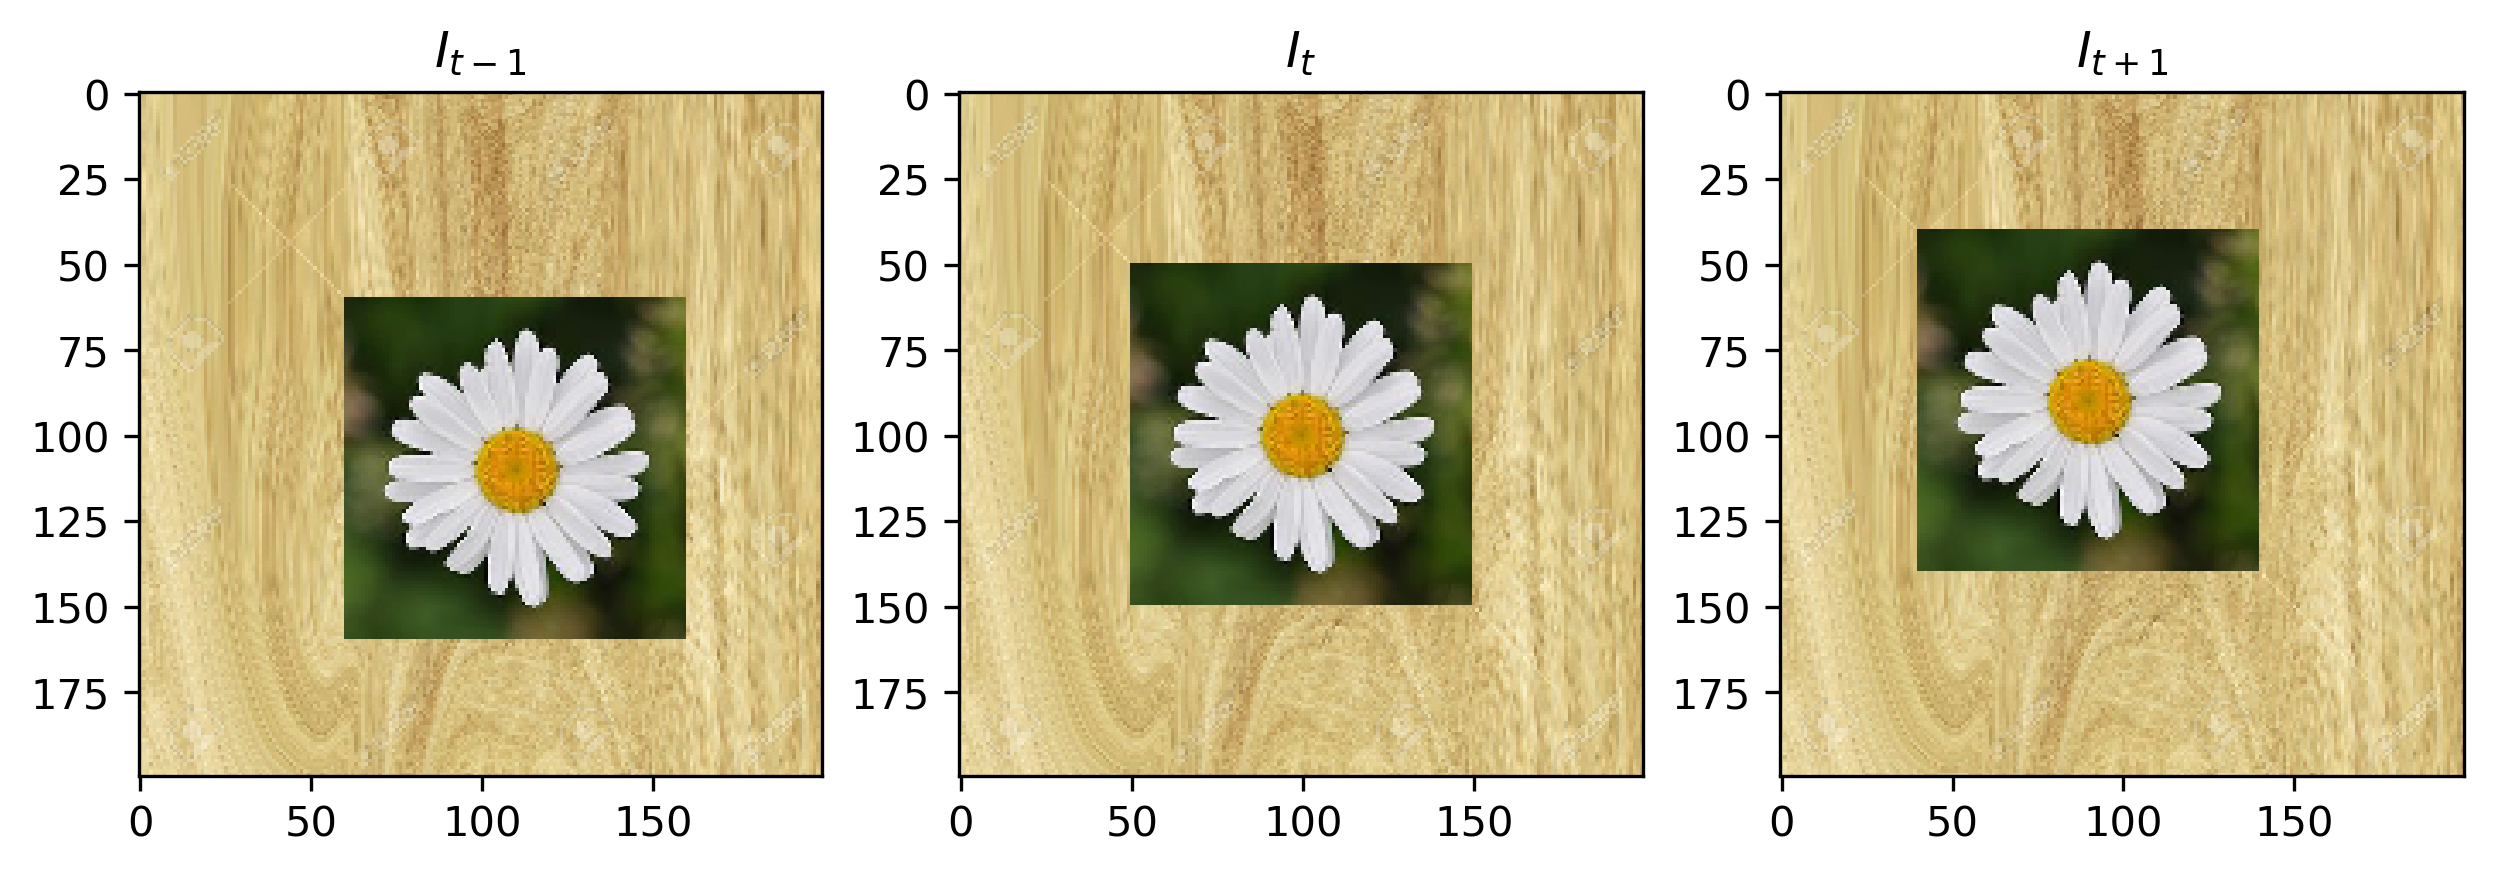

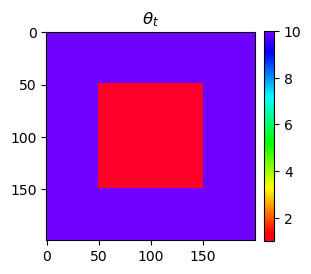

In [4]:
(img1, img2, img3), (depth1, depth2, depth3), (pose, pose_matrix, inv_pose_matrix, transfer_matrix) = setup_scene('both')
plt.figure(dpi=300,figsize = [10,10])
plt.subplot(131)
plt.imshow(img2[0].permute(1,2,0).cpu().numpy())
plt.title('$I_{t-1}$')
plt.subplot(132)
plt.imshow(img1[0].permute(1,2,0).cpu().numpy())
plt.title('$I_t$')
plt.subplot(133)
plt.imshow(img3[0].permute(1,2,0).cpu().numpy())
plt.title('$I_{t+1}$')
plt.show()
plt.figure(dpi=100, figsize = (10,10))
plt.subplot(131)
plt.imshow(depth1[0].cpu().numpy(), cmap=new_cmap)
plt.title('$\\theta_t$')
plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(depth2[0].cpu().numpy(), cmap='jet')
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(depth3[0].cpu().numpy(), cmap='jet')
# plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

## Inverse warp illustration

From now on, we call the function `inverse_warp`

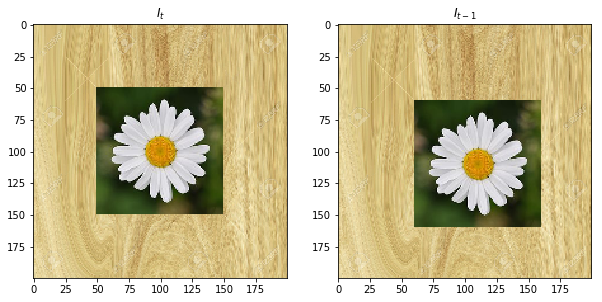

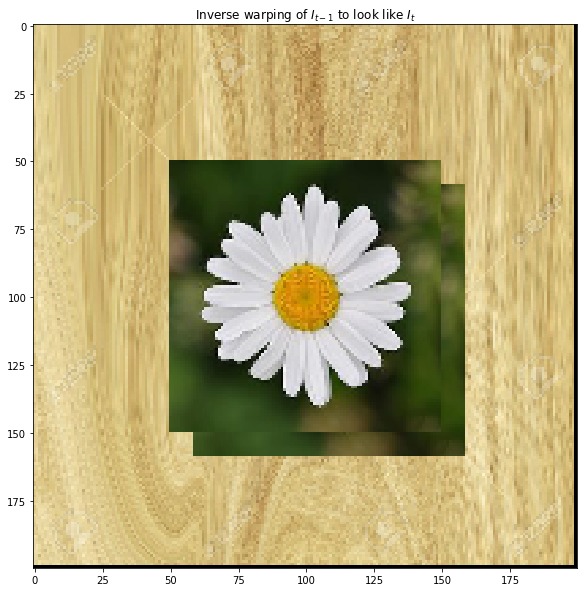

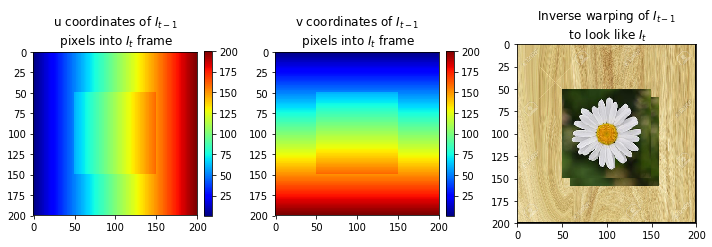

In [5]:
cam_coords = pixel2cam(depth1)
pose_mat = pose_vec2mat(pose)
rot = intrinsics @ pose_mat[:,:,:3] @ intrinsics_inv
tr = intrinsics @ pose_mat[:,:,-1:]
src_pixel_coords = cam2pixel(cam_coords, rot, tr)
projected_img = torch.nn.functional.grid_sample(img2, src_pixel_coords)
real_coords = 0.5*(src_pixel_coords + 1) * h
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img1[0].cpu().permute(1,2,0))
plt.title('$I_t$')
plt.subplot(122)
plt.imshow(img2[0].cpu().permute(1,2,0))
plt.title("$I_{t-1}$")
plt.figure(figsize=(10,10))
plt.imshow(projected_img[0].cpu().permute(1,2,0))
plt.title("Inverse warping of $I_{t-1}$ to look like $I_t$")
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(real_coords[0,:,:,0].cpu(),cmap='jet',vmax=h)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("u coordinates of $I_{t-1}$\n pixels into $I_t$ frame")
plt.subplot(132)
plt.imshow(real_coords[0,:,:,1].cpu(),cmap='jet',vmax=h)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("v coordinates of $I_{t-1}$\n pixels into $I_t$ frame")
plt.subplot(133)
plt.imshow(projected_img[0].cpu().permute(1,2,0))
plt.title("Inverse warping of $I_{t-1}$\n to look like $I_t$")
plt.tight_layout()

## The occlusion problem

diff map is not entirely black even though the depth maps is perfect !

Second diff map is not entirely black either, but the occluded artea are not the same

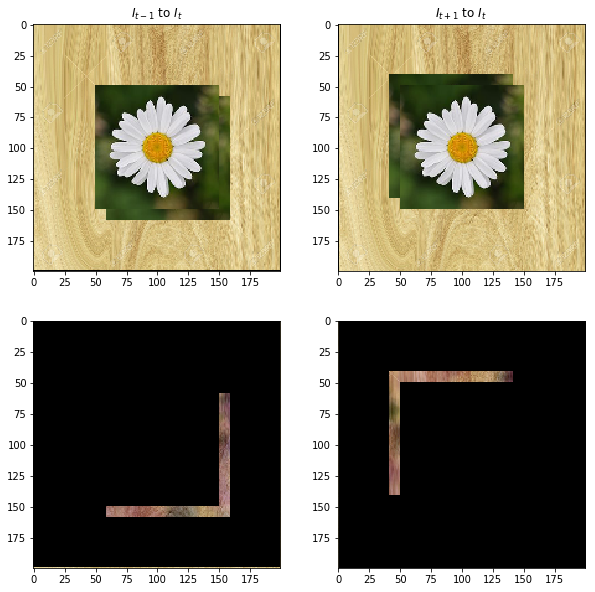

In [6]:
img2_warped = inverse_warp(img2, depth1, pose_matrix, intrinsics, intrinsics_inv)
img3_warped = inverse_warp(img3, depth1, inv_pose_matrix, intrinsics, intrinsics_inv)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img2_warped[0].cpu().permute(1,2,0).numpy())
plt.title("$I_{t-1}$ to $I_t$")
plt.subplot(222)
plt.imshow(img3_warped[0].cpu().permute(1,2,0).numpy())
plt.title("$I_{t+1}$ to $I_t$")
plt.subplot(223)
plt.imshow((img2_warped - img1)[0].abs().cpu().permute(1,2,0).numpy())
plt.subplot(224)
plt.imshow((img3_warped - img1)[0].abs().cpu().permute(1,2,0).numpy())
plt.show()

# Smooth depth or disp ?

Plane sample from Blender

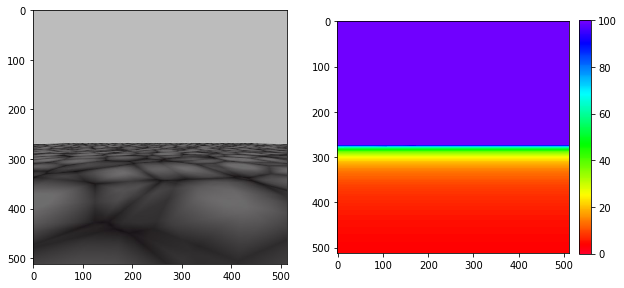

In [7]:
from imageio import imread
pic = imread('img/plane0.jpg')
dmap = np.clip(np.load('img/plane0.npy'),0,250)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(pic)
plt.subplot(122)
plt.imshow(dmap, cmap=new_cmap, vmin=0, vmax=100)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

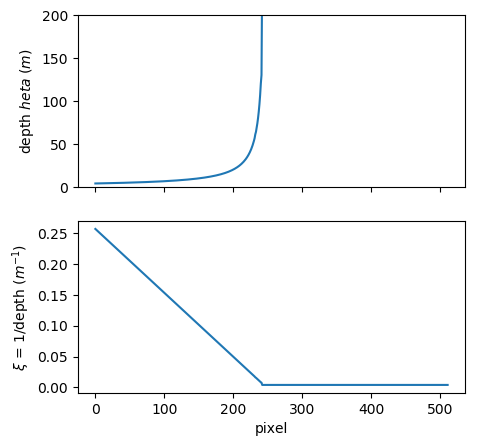

In [8]:
fig,axes = plt.subplots(2,1,figsize=(5,5),dpi=100,
                        sharex=True,sharey=False)
axes[0].plot(dmap[::-1,0])
axes[0].set_ylim((0, 200))
axes[0].set_ylabel('depth $\theta$ ($m$)')
axes[1].plot(1/dmap[::-1,0])
axes[1].set_ylabel("$\\xi$ = 1/depth ($m^{-1}$)")
plt.xlabel('pixel')
plt.show()

## First Optimization

You can play with the 6 different smooth loss to see how differently it behaves.

You can also try the occlusion mapper and the minimum loss.

In [9]:
from loss_functions import TV_loss, TVV_loss, diffusion_loss, grad_diffusion_loss, robust_diffusion_loss, robust_grad_diffusion_loss
from pytorch_direct_warp.occlusion_mapper import OcclusionMapper
mapper = OcclusionMapper(dilation=1)

def apply_smooth_loss(mode, xi, img1, weight, kappa):
    if mode == 'TV':
        return weight * TV_loss(xi, img1, kappa)
    elif mode == 'TVV':
        return weight * TVV_loss(xi, img1, kappa)
    elif mode == "regular_diff":
        return weight * diffusion_loss(xi, img1, kappa).mean()
    elif mode == "robust_diff":
        return weight * robust_diffusion_loss(xi, img1, kappa, gamma=0.1, iterations=10).mean()
    elif mode == 'regular_grad_diff':
        return weight * grad_diffusion_loss(xi, img1, kappa)
    elif mode == 'robust_grad_diff':
        return weight * robust_grad_diffusion_loss(xi, img1, kappa, gamma=0.1, iterations=10).mean()
    else:
        return 0

def one_iteration(depth, img1, img2, img3,
                  pose_matrix, inv_pose_matrix,
                  intrinsics, intrinsics_inv,
                  smooth_mode='TV', weight=0, kappa=50,
                  occluded=False, minloss=False):
    projected_img2 = inverse_warp(img2, depth, pose_matrix, intrinsics, intrinsics_inv)
    projected_img3 = inverse_warp(img3, depth, inv_pose_matrix, intrinsics, intrinsics_inv)
    diff_map2 = (projected_img2 - img1).abs().mean(dim=1, keepdim=True)
    diff_map3 = (projected_img3 - img1).abs().mean(dim=1, keepdim=True)
    if occluded:
        occlusion2 = mapper(depth, pose_matrix, intrinsics, intrinsics_inv).unsqueeze(1)
        diff_map2 *= (1 - occlusion2.float())

        occlusion3 = mapper(depth, inv_pose_matrix, intrinsics, intrinsics_inv).unsqueeze(1)
        diff_map3 *= (1 - occlusion3.float())
        with torch.no_grad():
            to_return = projected_img2* (1 - occlusion2).float(), projected_img3* (1 - occlusion3).float()
    else:
        to_return = projected_img2, projected_img3
    if minloss:
        diff_map = torch.stack([diff_map2, diff_map3])
        loss = 2*torch.min(diff_map, dim=0)[0].mean()
    else:
        diff_map = diff_map2 + diff_map3
        loss = diff_map.mean()
        
    
    xi = 1/depth.unsqueeze(1)
    
    loss += apply_smooth_loss(smooth_mode, xi, img1, weight, kappa)
        
    return (loss, *to_return)

def one_occluded_iteration(depth, img1, img2, img3,
                  pose_matrix, inv_pose_matrix,
                  intrinsics, intrinsics_inv,
                  smooth_mode='TV', weight=0, kappa=50):
    projected_img2 = inverse_warp(img2, depth_param, pose_matrix, intrinsics, intrinsics_inv)
    occlusion2 = mapper(depth_param, pose_matrix, intrinsics, intrinsics_inv).unsqueeze(1)
    filtered2 = (projected_img2 - img1) * (1 - occlusion2.float())
    
    projected_img3 = inverse_warp(img3, depth_param, inv_pose_matrix, intrinsics, intrinsics_inv)
    occlusion3 = mapper(depth_param, inv_pose_matrix, intrinsics, intrinsics_inv).unsqueeze(1)
    filtered3 = (projected_img3 - img1) * (1 - occlusion3.float())
    
    
    loss = filtered2.abs().mean()
    loss += filtered3.abs().mean()
    
    xi = 1/depth.unsqueeze(1)
    
    loss += apply_smooth_loss(smooth_mode, xi, img1, weight, kappa)
    
    return loss, projected_img2* (1 - occlusion2).float(), projected_img3* (1 - occlusion3).float()

In [10]:
def performance(estimation, target, first_estimation):
    b, *_ = estimation.shape
    logdiff = (torch.log(estimation) - torch.log(target)).view(b,-1).abs().mean(dim=1)
    logdiff0 = (torch.log(first_estimation) - torch.log(target)).view(b,-1).abs().mean(dim=1)
    return 1 - (logdiff/logdiff0).clamp(max=1)

@torch.no_grad()
def joint_performance(*args):
    perf = performance(*args)
    return torch.sqrt(perf.prod()).item()
    

# Video

This will display the evolution of the optimization

If occlusion module is selected, discarded areas will appear black

(NB: you must have ffmpeg to make this cell work)

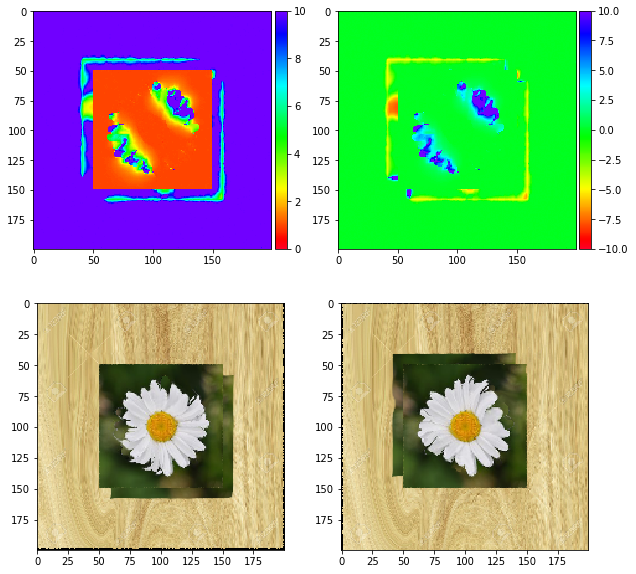

In [11]:
from torch.nn.functional import interpolate
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10, 10))
frames = 100
scene_to_show = 0

inv_pose_matrix = invert_mat(pose_matrix)
depth_param = torch.nn.Parameter(bg_depth*torch.ones_like(depth1).to(device))
#disp_param = torch.nn.Parameter(1*torch.ones(1,h,h).to(device))
#depth_param =torch.nn.Parameter(depth1.clone())
#pose_param = torch.nn.Parameter(torch.zeros(1,3).to(device))
optimizer = torch.optim.Adam([depth_param], lr=0.15, betas=[0.9, 0.999])

ax1 = fig.add_subplot(221)
depth_plot = plt.imshow(depth_param[scene_to_show].cpu().detach().numpy(), animated=True, cmap=new_cmap, vmin=0, vmax=bg_depth)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(depth_plot, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
depth_diff = plt.imshow((depth_param - depth1)[scene_to_show].cpu().detach().numpy(), animated=True, cmap=new_cmap, vmin=-10, vmax=10)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(depth_diff, cax=cax, orientation='vertical')

plt.subplot(223)
img_warped2 = inverse_warp(img2, depth_param, pose_matrix, intrinsics, intrinsics_inv)
img_warped2_plot = plt.imshow(img_warped2[scene_to_show].detach().cpu().permute(1,2,0).numpy(), animated=True, cmap=new_cmap)
plt.subplot(224)
img_warped3 = inverse_warp(img3, depth_param, inv_pose_matrix, intrinsics, intrinsics_inv)
img_warped3_plot = plt.imshow(img_warped3[scene_to_show].detach().cpu().permute(1,2,0).numpy(), animated=True, cmap=new_cmap)
#img_warped3_plot = plt.imshow(depth_param[0].detach().cpu().numpy(), animated=True, cmap='jet',vmin=1, vmax=10)
losses = []

def animate(i):
    global depth_param
    #depth_param = disp_param
    for j in range(200):
        loss, proj_img2, proj_img3 = one_iteration(depth_param, img1, img2, img3,
                                                   pose_matrix, inv_pose_matrix,
                                                   intrinsics, intrinsics_inv,
                                                   smooth_mode = 'regular_diff',
                                                   weight=30, kappa=0.5, occluded=False, minloss=False)
        if loss.item() != loss.item():
            print('nan')
        with torch.no_grad():
            losses.append((torch.log(depth_param)-torch.log(depth1))[0].abs().mean().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            depth_param.clamp_(min=1e-3)


    depth_plot.set_array(depth_param[scene_to_show].detach().cpu().numpy())
    depth_diff.set_array((depth_param - depth1)[scene_to_show].detach().cpu().numpy())
    img_warped2_plot.set_array(proj_img2[scene_to_show].detach().cpu().permute(1,2,0).numpy())
    img_warped3_plot.set_array(proj_img3[scene_to_show].detach().cpu().permute(1,2,0).numpy())
    return (depth_plot, depth_diff, img_warped2_plot, img_warped3_plot)
ani = animation.FuncAnimation(fig, animate, interval=100, frames=frames, blit=True)
HTML(ani.to_html5_video())
#plt.figure()
#plt.plot(losses)

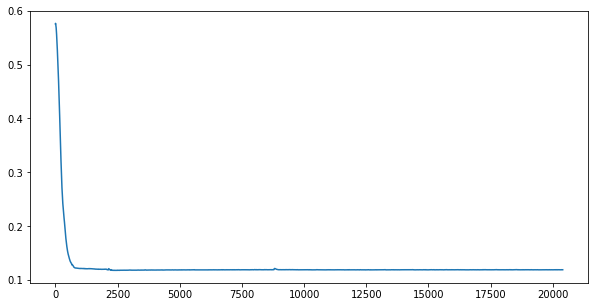

In [12]:
plt.figure(figsize=(10,5))
plt.plot(losses)

# quantitative comparison

5 different smooth loss are tested, smooth loss is applied on disparity (1/depth)

In [13]:
def one_optim(frames=10000, lr=0.15, verbose=True, **params):
    b, *_ = depth1.shape
    depth_param = torch.nn.Parameter(bg_depth*torch.ones_like(depth1).to(device))
    optimizer = torch.optim.Adam([depth_param], lr=lr, betas=[0.9, 0.999])
    losses = []
    perf = []
    if verbose:
        iterator = tqdm(range(frames), desc='{}, k={}'.format(params['smooth_mode'], params['kappa']))
    else:
        iterator = range(frames)
    for i in iterator:
        loss, proj_img2, proj_img3 = one_iteration(depth_param, img1, img2, img3,
                                                   pose_matrix, inv_pose_matrix,
                                                   intrinsics, intrinsics_inv,
                                                   **params)
        diff = (torch.log(depth1) - torch.log(depth_param)).detach().view(b,-1).abs().mean(dim=1).cpu()
        losses.append(diff)
        perf.append(joint_performance(depth_param, depth1, torch.tensor(bg_depth, dtype=torch.float)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            depth_param.clamp_(min=1e-3)
    losses = torch.stack(losses, dim=1)  # [B, N]
    results = depth_param.detach().cpu().numpy()
    return [losses, perf, results]

### Ideal hyperparameters without occlusion module

In [ ]:
'''
No occ
TV (1, 0.8) 0.3525449 0.35324106 0.33393955
TVV (1, 3.0) 0.28964964 0.3448651 0.3970259
regular_diff (30, 0.3) 0.6688973 0.0896724 0.16252081
robust_diff (100, 0.3) 0.687293 0.031041713 0.12290674
regular_MD_diff (30, 0.3) 0.5444941 0.24647595 0.263752
robust_MD_diff (30, 0.3) 0.56747335 0.27295688 0.26557225
'''

overall_losses = {}
overall_losses['nothing'] = one_optim(smooth_mode='nothing', weight=0, kappa=50)
overall_losses['TV'] = one_optim(smooth_mode = 'TV', weight=1, kappa=0.8)
overall_losses['TVV'] = one_optim(smooth_mode = 'TVV', weight=1, kappa=3.0)
overall_losses['diffusion'] = one_optim(smooth_mode = 'regular_diff', weight=30, kappa=0.3)
overall_losses['robust diffusion'] = one_optim(smooth_mode = 'robust_diff', weight=100, kappa=0.3)
overall_losses['robust gradient diffusion'] = one_optim(smooth_mode='robust_MD_diff', weight=30, kappa=0.3)
overall_losses['gradient diffusion'] = one_optim(smooth_mode='regular_MD_diff', weight=30, kappa=0.3)

### Ideal hyperparameters *with* occlusion module

In [ ]:
'''
with Occ
TV (1, 0.8) 0.35476825 0.36777163 0.37956497
TVV (0.3, 3.0) 0.3080813 0.3424056 0.37141925
regular_diff (30, 1.0) 0.74005187 0.09690867 0.19969822
robust_diff (100, 0.1) 0.639128 0.09440826 0.12868184
regular_MD_diff (30, 0.8) 0.64225495 0.20261262 0.24996623
robust_MD_diff (100, 0.3) 0.64799905 0.1956505 0.23776002
'''
overall_occ_losses = {}
overall_occ_losses['nothing'] = one_optim(smooth_mode='nothing', weight=0, kappa=50, occluded=True)
overall_occ_losses['TV'] = one_optim(smooth_mode = 'TV', weight=1, kappa=0.8, occluded=True)
overall_occ_losses['TVV'] = one_optim(smooth_mode = 'TVV', weight=0.3, kappa=3.0, occluded=True)
overall_occ_losses['diffusion'] = one_optim(smooth_mode = 'regular_diff', weight=30, kappa=1.0, occluded=True)
overall_occ_losses['robust diffusion'] = one_optim(smooth_mode = 'robust_diff', weight=100, kappa=0.1, occluded=True)
overall_occ_losses['robust gradient diffusion'] = one_optim(smooth_mode='robust_MD_diff', weight=30, kappa=0.8, occluded=True)
overall_occ_losses['gradient diffusion'] = one_optim(smooth_mode='regular_MD_diff', weight=100, kappa=0.3, occluded=True)

# Displaying Result

You can decide which result to display. If you want to compare occluded and not occluded, see next cell

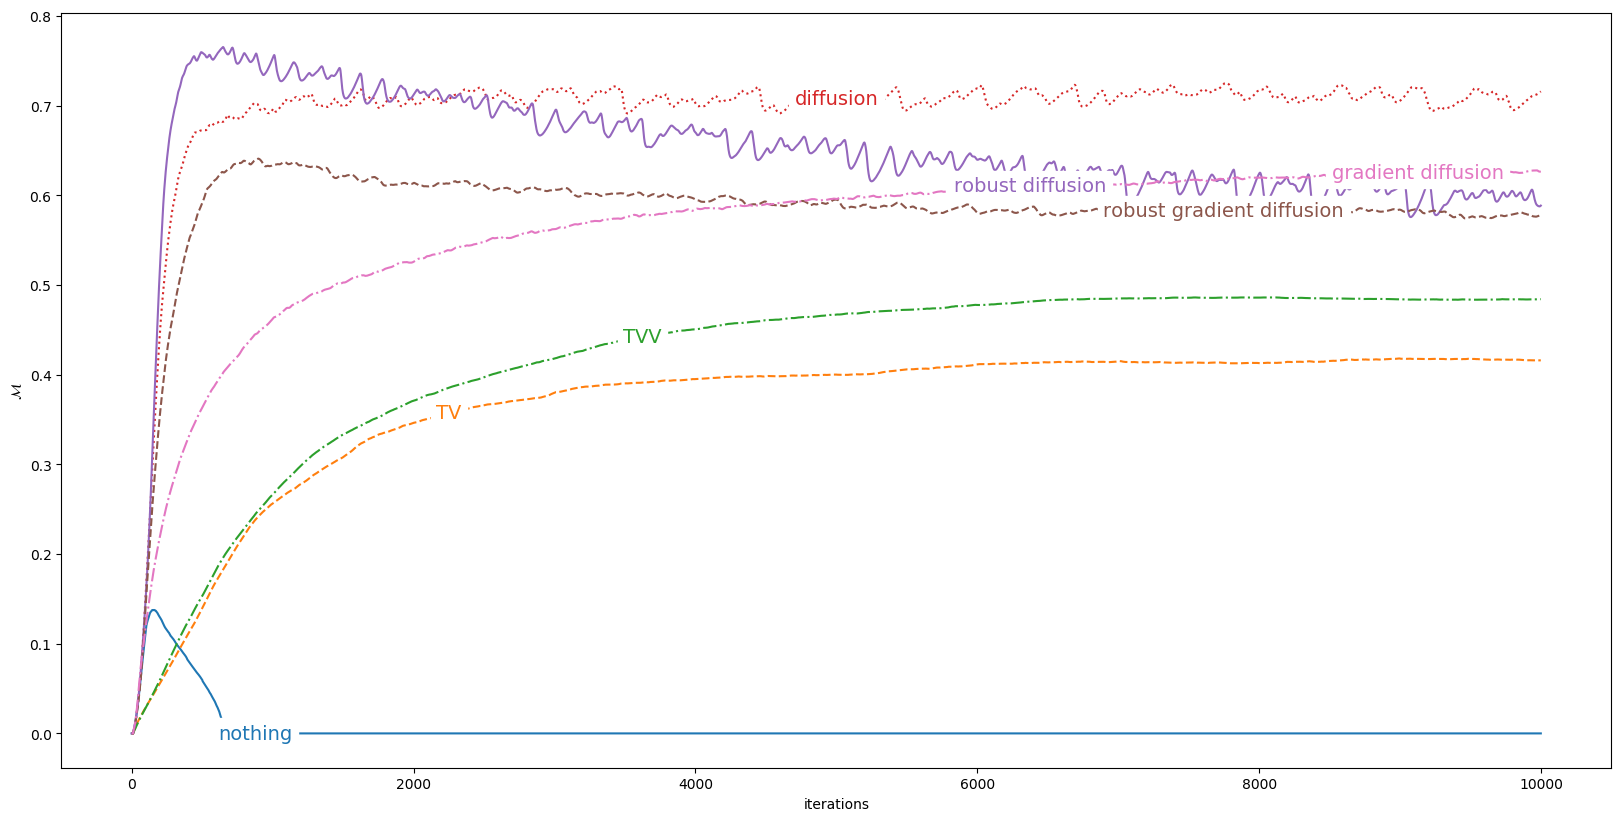

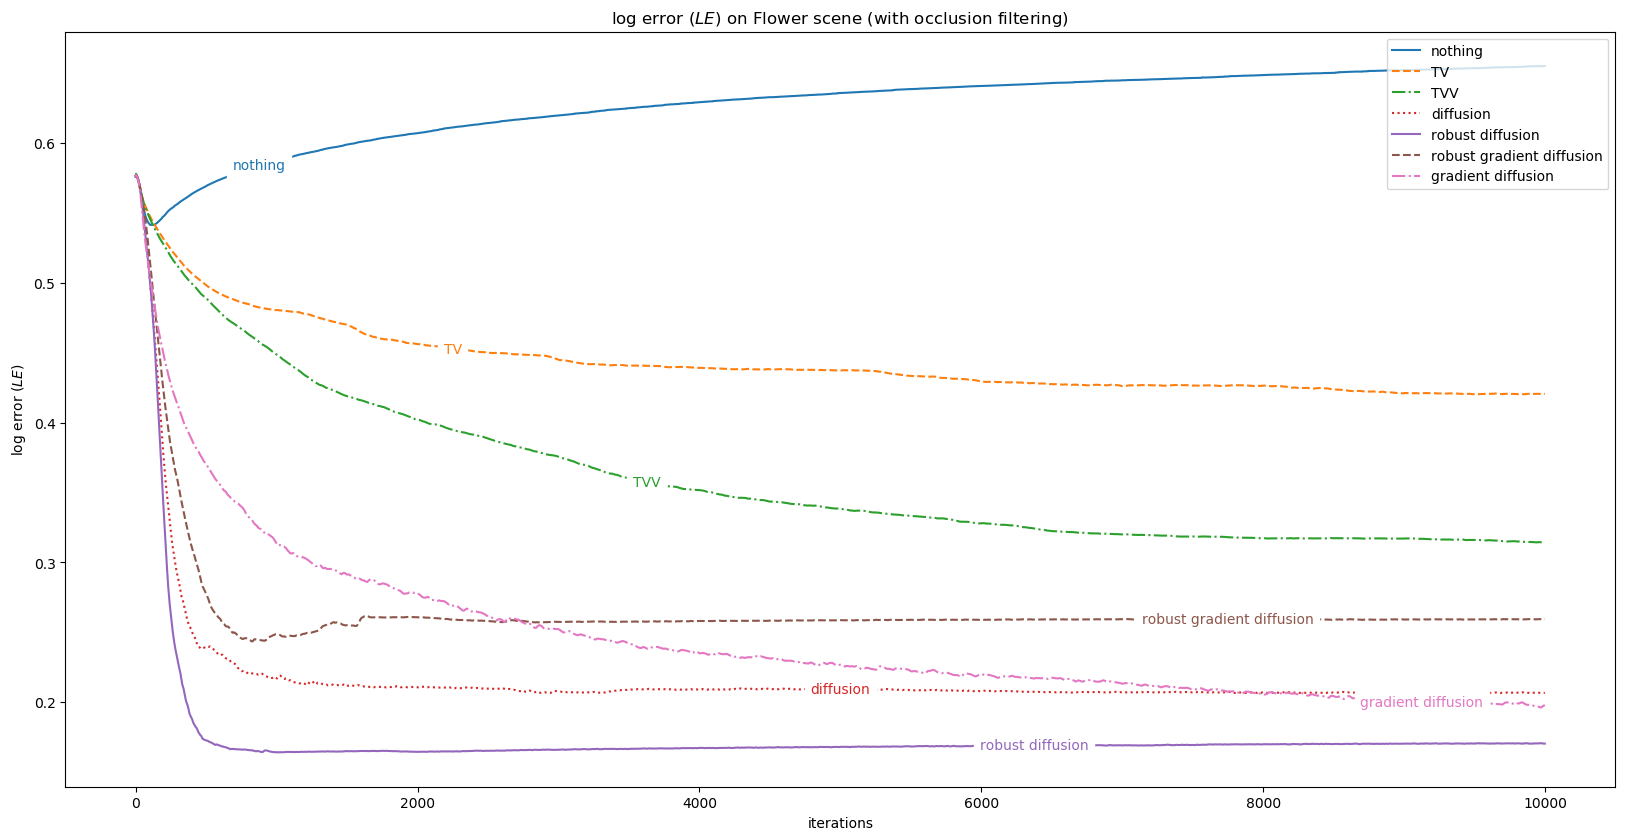

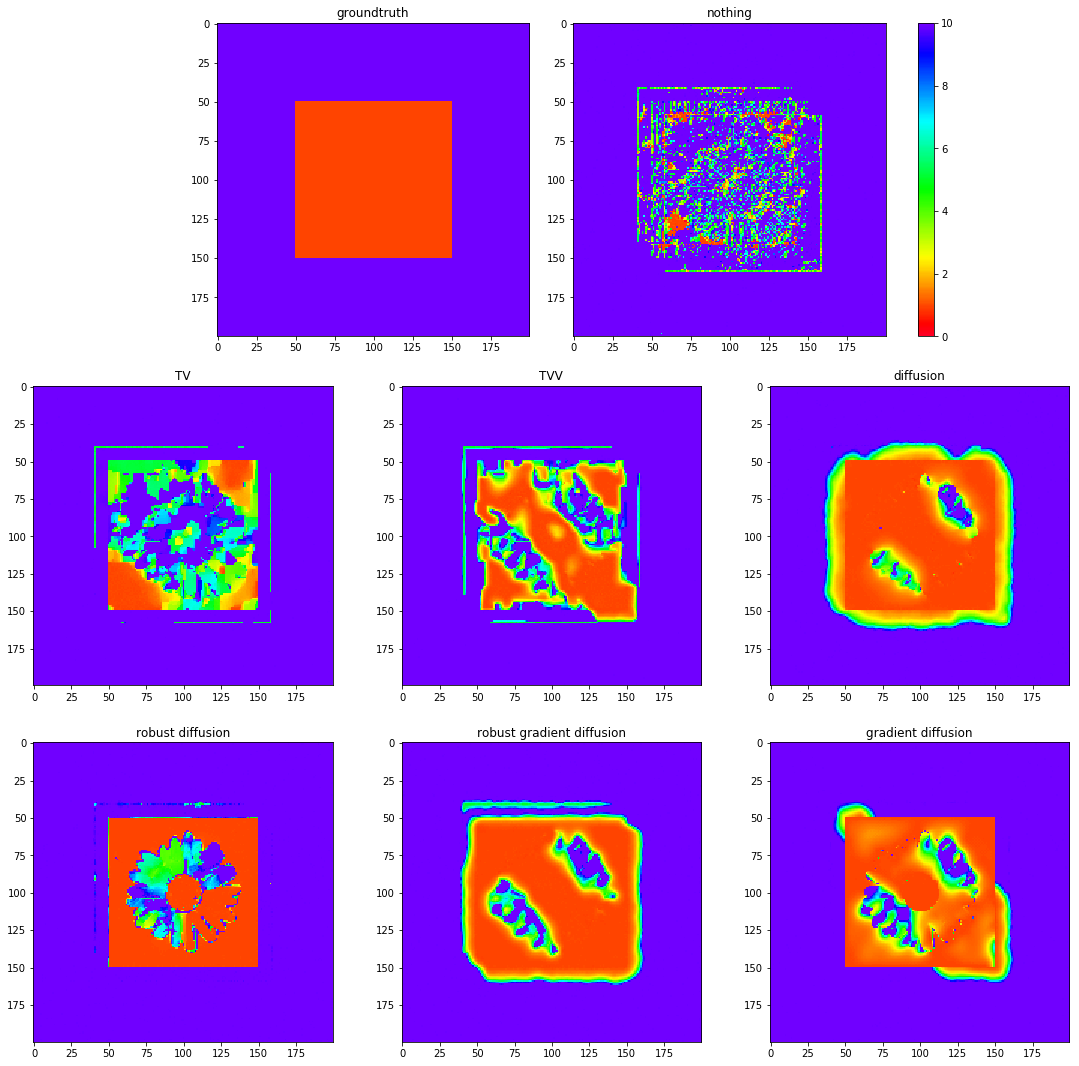

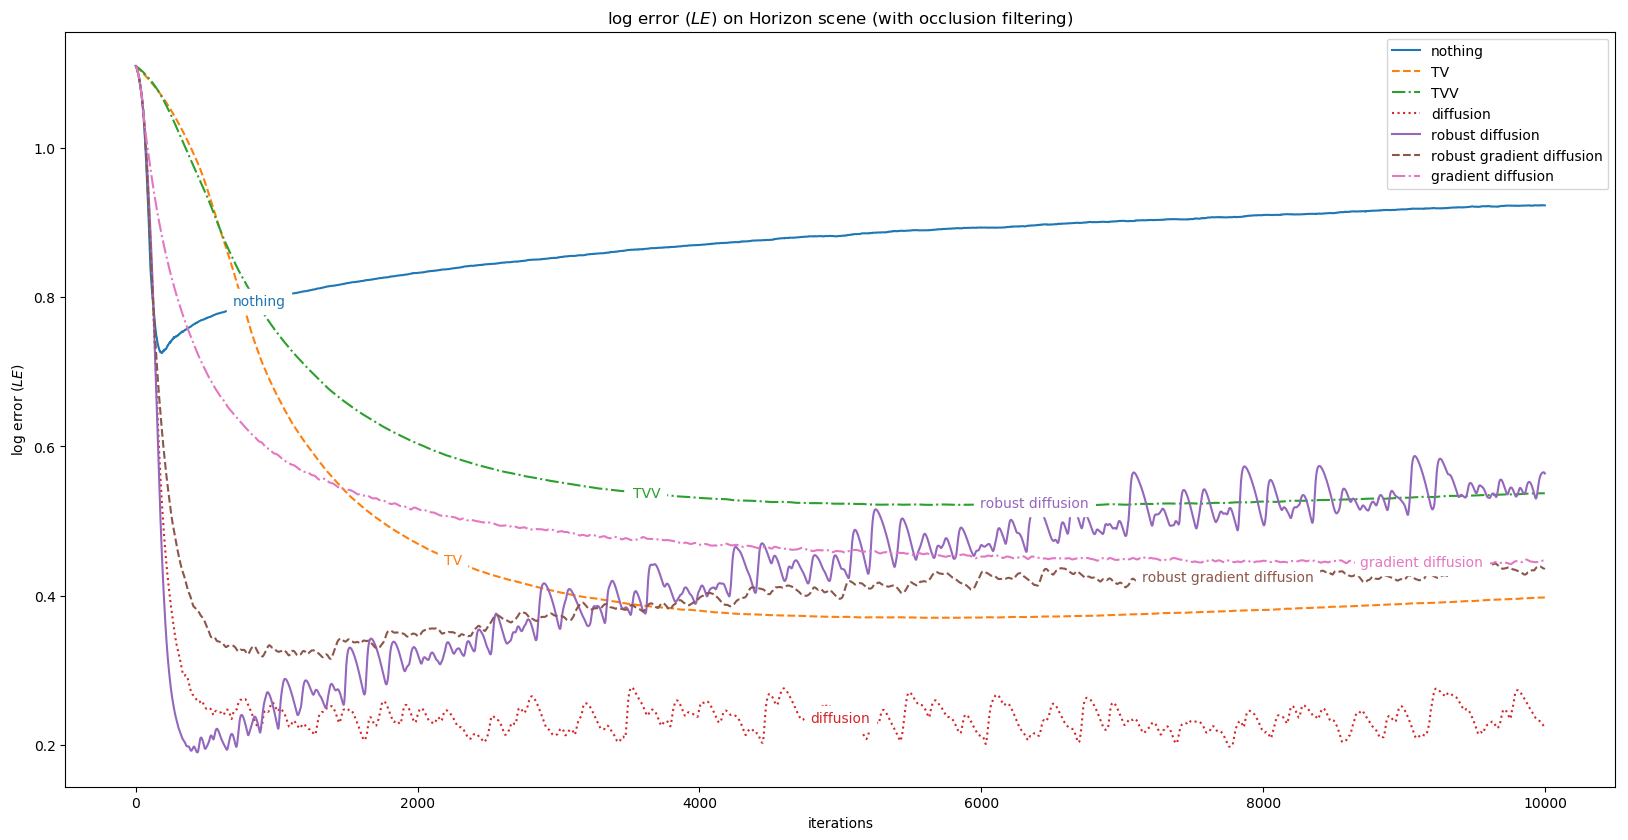

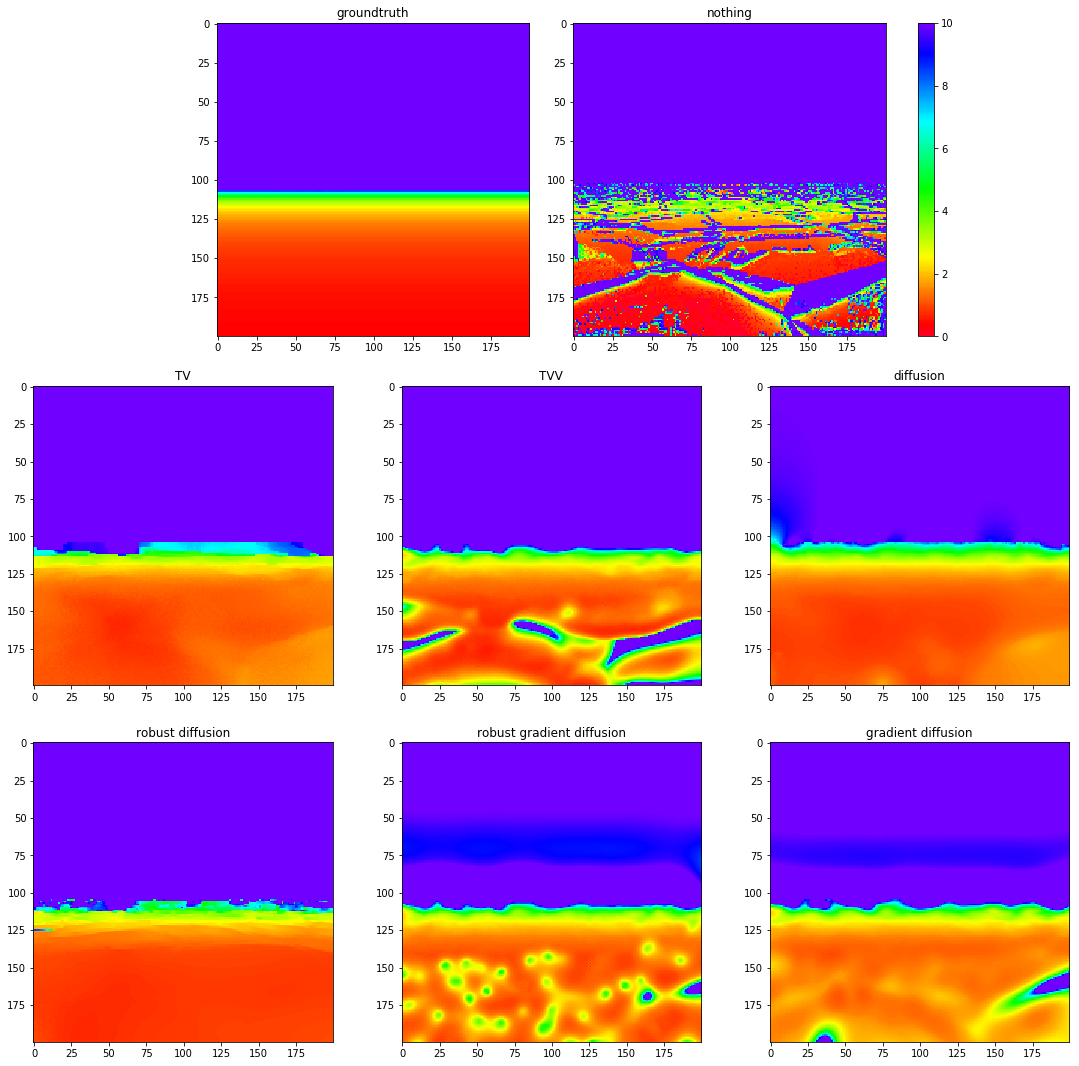

In [145]:
linestyles = ['-', '--', '-.', ':']
with_occ=True

losses = overall_occ_losses if with_occ else overall_losses

plt.figure(figsize=(20,10), dpi=100)
for (loss_name, loss) ,style in zip(losses.items(), cycle(linestyles)):
    #print(loss[1])
    plt.plot(loss[1], label=loss_name, linestyle=style)
labelLines(plt.gca().get_lines(),align=False,fontsize=14,xvals=xvals)
plt.xlabel('iterations')
plt.ylabel('$\mathcal{M}$')
plt.show()

for scene , name in zip([0,1], ["Flower", "Horizon"]):
    fig1, ax1 = plt.subplots(figsize=(20,10), dpi=100)
    for (loss_name, loss) ,style in zip(losses.items(), cycle(linestyles)):
        ax1.plot(loss[0][scene].numpy(), label=loss_name, linestyle=style)
    plt.legend(loc=1)
    xvals = [6000,1800,3000,850,3000,1500,1500,1500,3500,2000,7000]
    xvals=None
    #xvals = range(0, 10*len(overall_losses.keys()), 100)
    labelLines(plt.gca().get_lines(),align=False,fontsize=10,xvals=xvals)
    plt.xlabel('iterations')
    plt.ylabel('log error ($LE$)')
    plt.title('log error ($LE$) on {} scene ({} occlusion filtering)'.format(name, "with" if with_occ else "no"))
    plt.show()


    fig = plt.figure(figsize=(15,15))
    subplots_adjust(wspace=0,hspace=0)
    num_plots = len(losses.keys()) + 1
    grid = int(num_plots//3) + 1
    ax = subplot2grid((grid,6), (0, 1), colspan=2)
    plt.imshow( depth1.cpu().numpy()[scene], cmap=new_cmap, vmin=0, vmax=bg_depth)
    plt.title('groundtruth')

    ax = subplot2grid((grid,6), (0,3), colspan=2)
    result = losses['nothing']
    plt.imshow( result[2][scene], cmap=new_cmap, vmin=0, vmax=bg_depth)
    plt.title('nothing')

    for i, (loss_name, result) in enumerate(losses.items()):
        if 'nothing' not in loss_name:
            plt.subplot(grid, 3, i+3)
            plt.imshow( result[2][scene], cmap=new_cmap, vmin=0, vmax=bg_depth)
            plt.title(loss_name)
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.685, 0.015, 0.29])
    plt.colorbar(cax=cbar_ax)
    plt.show()

# Comparison between occluded and not occluded

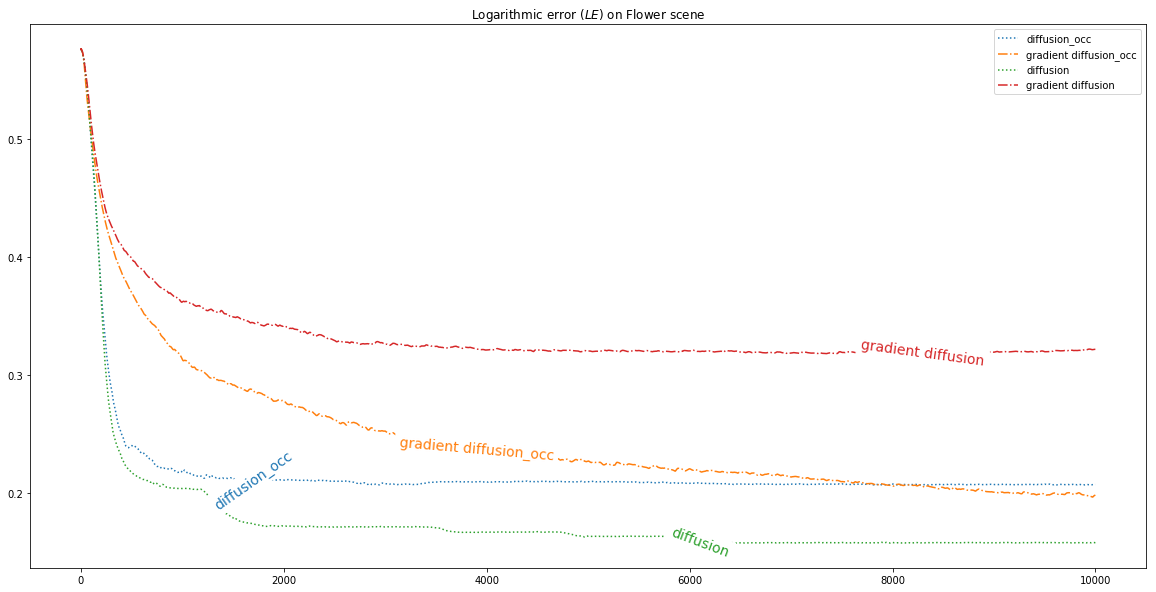

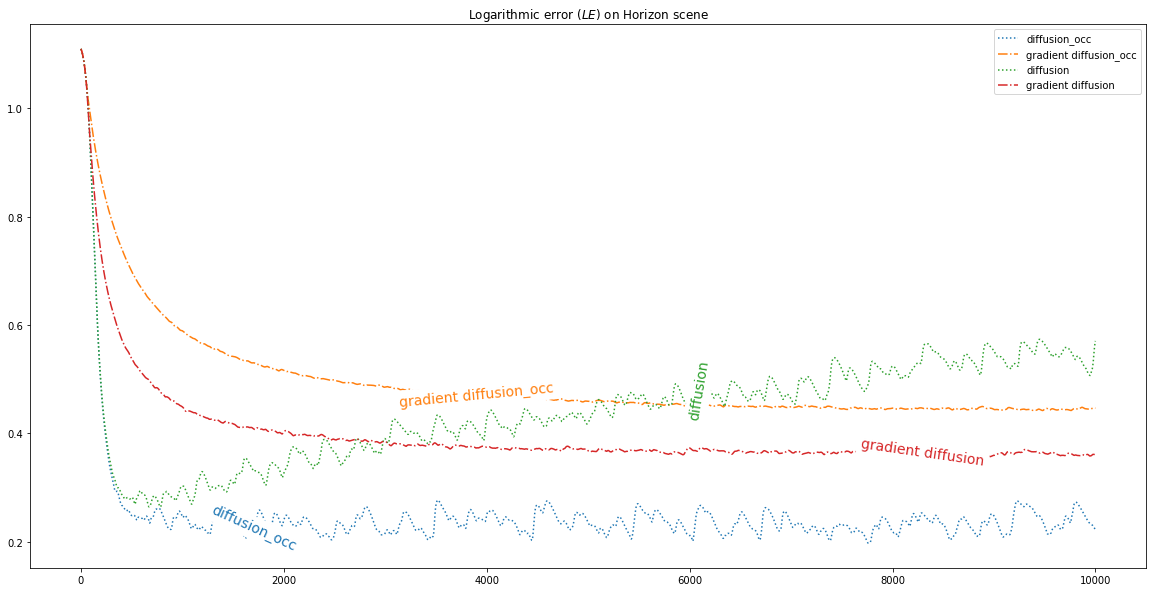

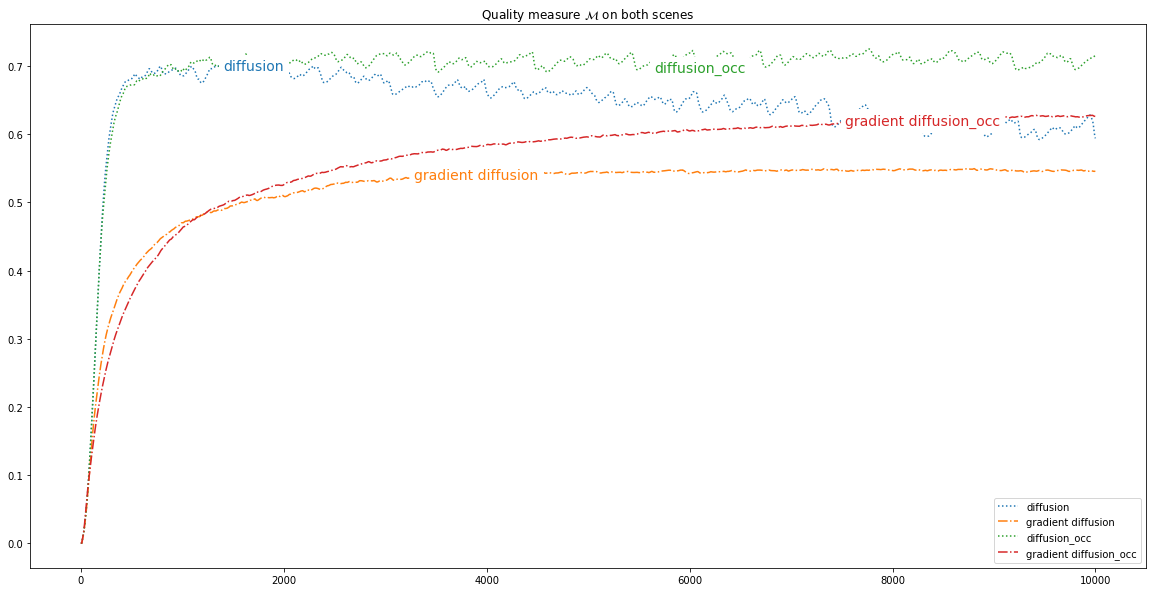

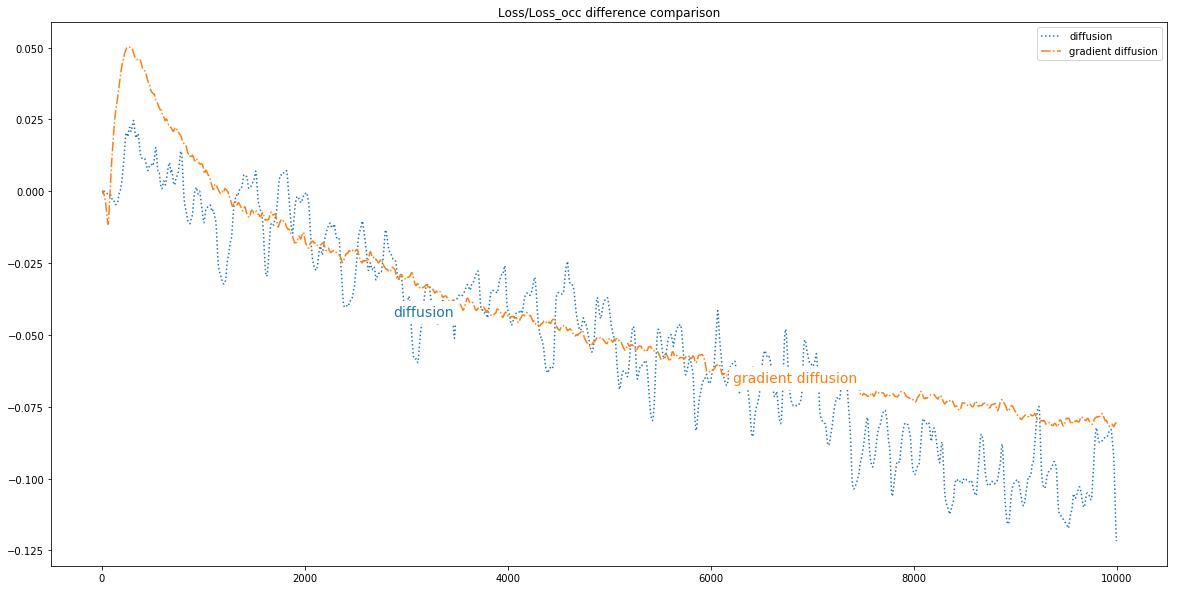

In [146]:
from labellines import labelLine, labelLines
from itertools import cycle
import matplotlib
plt.rcParams["figure.figsize"] = [20,10]
linestyles = ['-', '--', '-.', ':']
loss_to_test = ['gradient diffusion', 'diffusion']
for scene, name in zip([0,1], ["Flower", "Horizon"]):
    fig1, ax1 = plt.subplots()
    for (loss_name, loss) ,style in zip(overall_occ_losses.items(), cycle(linestyles)):
        if loss_to_test is None or loss_name in loss_to_test:
            ax1.plot(loss[0][scene].numpy(), label=loss_name+ '_occ', linestyle=style)
    for (loss_name, loss) ,style in zip(overall_losses.items(), cycle(linestyles)):
        if loss_to_test is None or loss_name in loss_to_test:
            ax1.plot(loss[0][scene].numpy(), label=loss_name, linestyle=style)
    plt.legend()
    labelLines(plt.gca().get_lines(),align=True,fontsize=14)
    plt.title("Logarithmic error ($LE$) on {} scene".format(name))
    plt.show()


plt.figure()
for (loss_name, loss) ,style in zip(overall_losses.items(), cycle(linestyles)):
    if loss_to_test is None or loss_name in loss_to_test:
        plt.plot(loss[1], label=loss_name, linestyle=style)
for (loss_name, loss) ,style in zip(overall_occ_losses.items(), cycle(linestyles)):
    if loss_to_test is None or loss_name in loss_to_test:
        plt.plot(loss[1], label=loss_name + '_occ', linestyle=style)
labelLines(plt.gca().get_lines(),align=False,fontsize=14)
plt.legend()
plt.title("Quality measure $\mathcal{M}$ on both scenes")
plt.show()

plt.figure()
for (loss_name, loss) ,style in zip(overall_losses.items(), cycle(linestyles)):
    if loss_to_test is None or loss_name in loss_to_test:
        loss1 = loss[1]
        loss2 = overall_occ_losses[loss_name][1]
        diff = [l1 - l2 for (l1,l2) in zip(loss1, loss2)]
        plt.plot(diff, label=loss_name, linestyle=style)
labelLines(plt.gca().get_lines(),align=False,fontsize=14)
plt.legend()
plt.title("Loss/Loss_occ difference comparison")
plt.show()

# Hyperparameter Search

In [148]:
from labellines import labelLine, labelLines
from itertools import cycle
import pickle
weights = [0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000,30000]
kappas = [0.01,0.03,0.1,0.3,1.0,3.0,100.0]

def test_weights(smooth_mode, kappa):
    maps = []
    final_losses_list = []
    for w in tqdm(weights):
        losses, result = one_optim(smooth_mode=smooth_mode, weight=w, kappa=kappa, verbose=False, frames=1000, lr=0.05)
        final_losses = losses[:,-1]
        final_losses_list.append(final_losses)
        maps.append(result)
    losses = torch.stack(final_losses_list, dim=1)
    losses_norm = (losses/losses[:,:1]).clamp(max=1)
    optimal = 1 - (1-losses_norm).prod(dim=0, keepdim=True)
    losses = torch.cat((losses, optimal))
    x = torch.argmin(losses, dim=-1)
    results = {'errors': losses, 'best_results': maps[x[-1].item()], 'minima': x}
    return results

def test_kappas(smooth_mode, weight):
    maps = []
    final_losses_list = []
    for k in tqdm(kappas):
        losses, result = one_optim(smooth_mode=smooth_mode, weight=weight, kappa=k, verbose=False, frames=10000, lr=0.05)
        final_losses = losses[:,-1]
        final_losses_list.append(final_losses)
        maps.append(result)
    losses = torch.stack(final_losses_list, dim=1)
    losses_norm = (losses/losses[:,:1]).clamp(max=1)
    optimal = 1 - (1-losses_norm).prod(dim=0, keepdim=True)
    losses = torch.cat((losses, optimal))
    x = torch.argmin(losses, dim=-1)
    results = {'errors': losses, 'best_results': maps[x[-1].item()], 'minima': x}
    return results

def test_both(smooth_mode,occluded=False):
    perf_tensor = torch.zeros((len(weights), len(kappas), 3))
    result_maps = torch.zeros_like(depth1)
    with tqdm(total = len(weights)*len(kappas)) as pbar:
        for i,k in enumerate(kappas):
            for j,w in enumerate(weights):
                pbar.update(1)
                losses, perf, result = one_optim(smooth_mode=smooth_mode,
                                                 weight=w, kappa=k,
                                                 verbose=False, frames=5000, lr=0.15,
                                                 occluded=occluded)
                perf_tensor[j,i,0] = perf[-1]
                perf_tensor[j,i,1:] = losses[:,-1]
                if perf[-1] > perf_tensor[:,:,0].max():
                    result_maps = result
    idx = torch.argmax(perf_tensor[:,:,0])
    i,j = idx//len(kappas), idx%len(kappas)
    w,k = weights[i], kappas[j]
    return {'errors': perf_tensor, 'best_results': result_maps, 'minima': (w,k)}

# Let's search !

(NB: this will take 12hours with occlusion module and without)

In [ ]:
hyperp = {}
hyperp['TV'] = test_both('TV')
hyperp['TVV'] = test_both('TVV')

hyperp['diffusion'] = test_both('regular_diff')
hyperp['robust diffusion'] = test_both('robust_diff')

hyperp['gradient diffusion'] = test_both('regular_MD_diff')
hyperp['robust gradient diffusion'] = test_both('robust_MD_diff')

with open('both_scenes_10000.pickle', 'wb') as handle:
    pickle.dump(hyperp, handle)

In [ ]:
hyperp_occ = {}
hyperp_occ['TV'] = test_both('TV', occluded=True)
hyperp_occ['TVV'] = test_both('TVV', occluded=True)

hyperp_occ['diffusion'] = test_both('regular_diff', occluded=True)
hyperp_occ['robust diffusion'] = test_both('robust_diff', occluded=True)

hyperp_occ['gradient diffusion'] = test_both('regular_MD_diff', occluded=True)
hyperp_occ['robust gradient diffusion'] = test_both('robust_MD_diff', occluded=True)

with open('both_scenes_occ_10000.pickle', 'wb') as handle:
    pickle.dump(hyperp_occ, handle)

# Display hyper parameter search results

this will read files saved above in order to not have to run it each time.

                             Best HPs         M   Delta M  LE Flower  LE Plane
loss                                                                          
TV                           (3, 0.1)  0.324930 -0.467036   0.393109  0.740419
TVV                          (1, 1.0)  0.300545 -0.353216   0.352660  0.851164
diffusion                   (30, 0.3)  0.667593 -0.305300   0.163082  0.419741
robust diffusion           (100, 0.3)  0.687293 -0.673019   0.122136  0.444456
gradient diffusion          (30, 0.3)  0.544494 -0.115311   0.320266  0.368213
robust gradient diffusion  (100, 1.0)  0.570228 -0.138599   0.267509  0.435731


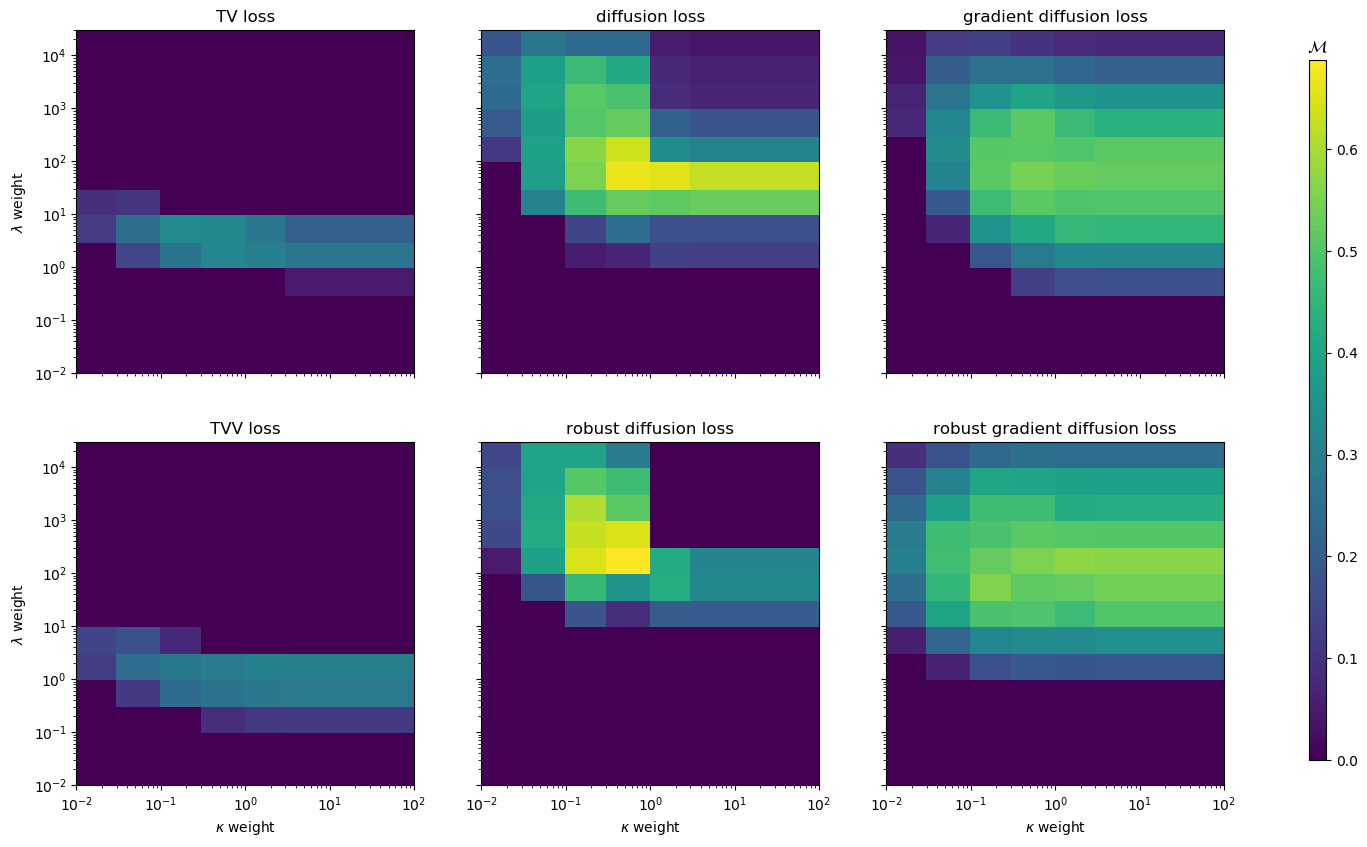

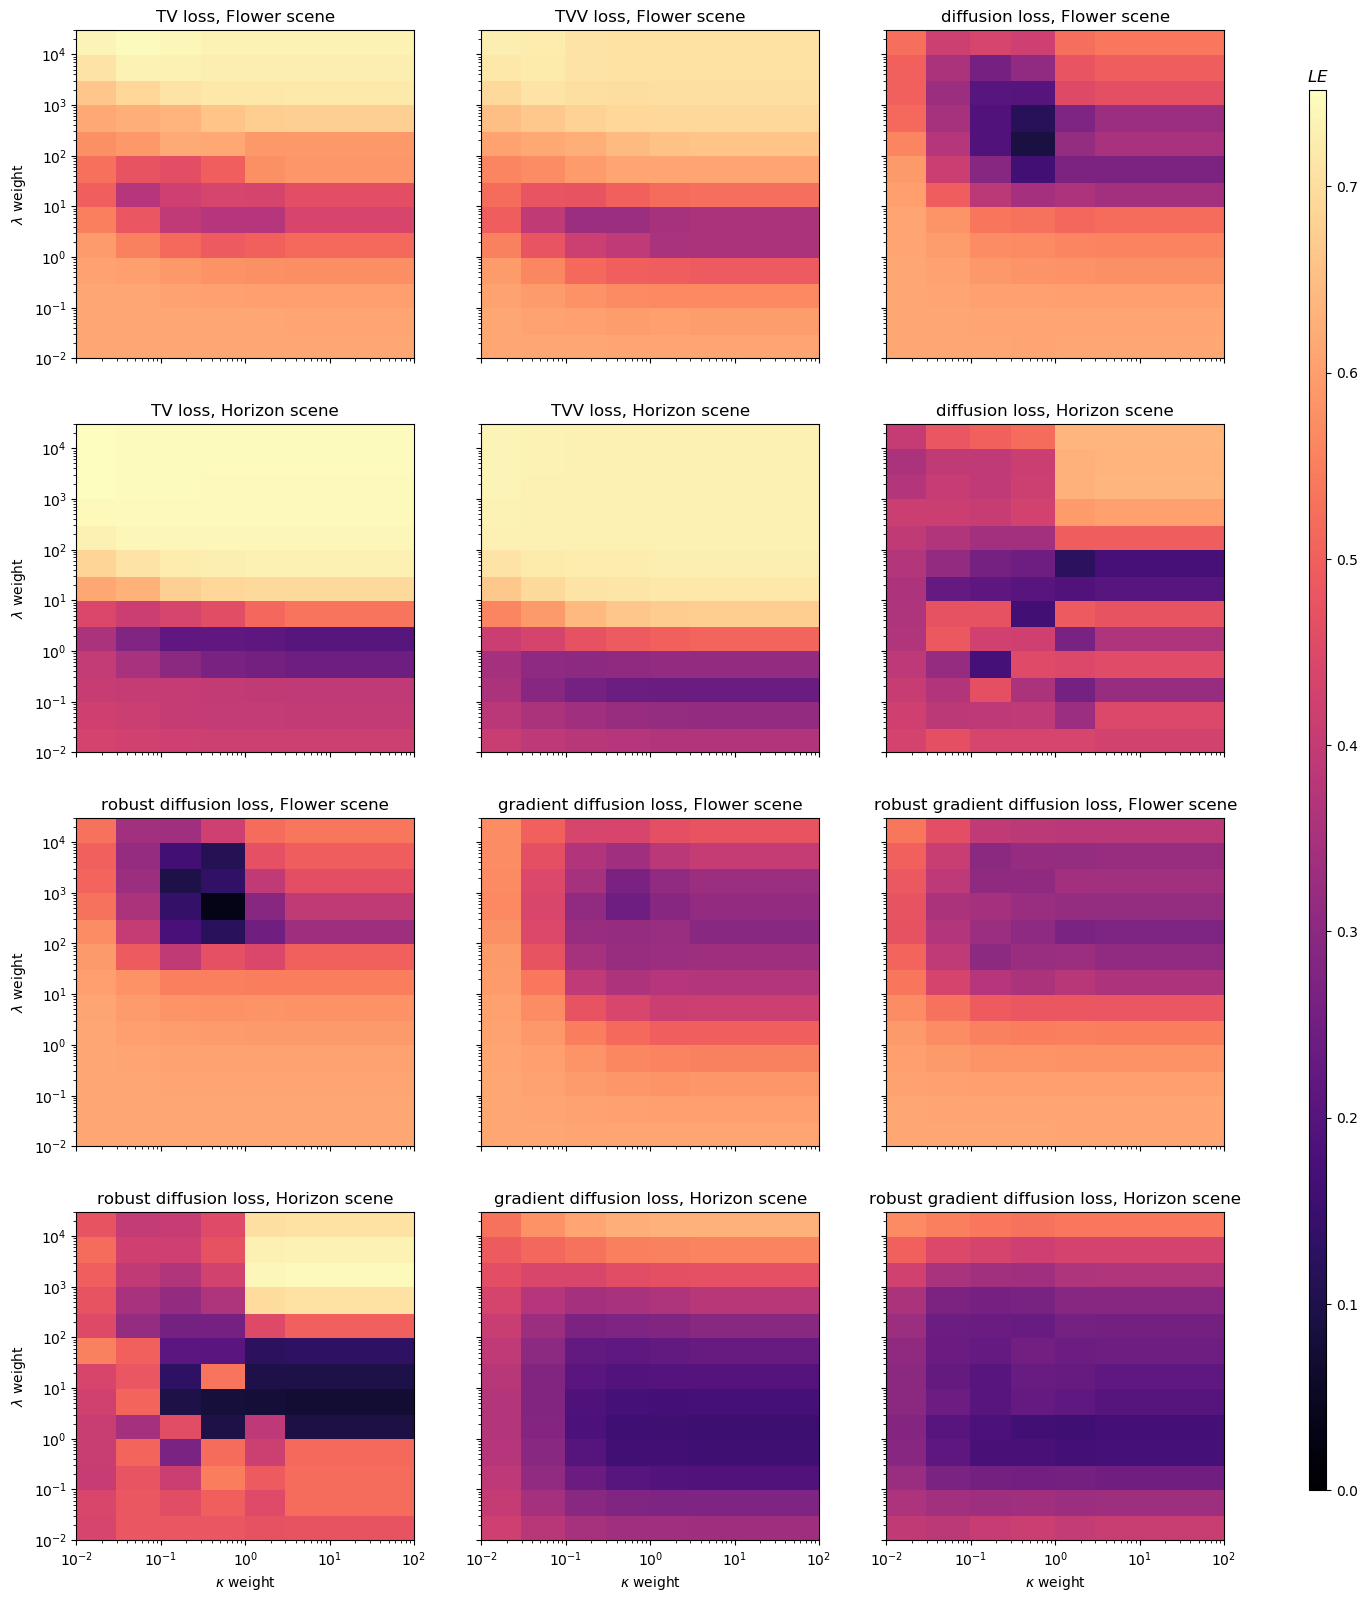

In [188]:
with_occ = False
hyperp_file = 'both_scenes{}_10000.pickle'.format("_occ" if with_occ else "")

with open(hyperp_file, 'rb') as handle:
    to_display = pickle.load(handle)

result_table = []
for loss, result in to_display.items():
    a = result['errors'].numpy()
    #a = np.delete(a,bad_weights, axis=0)
    #a = np.delete(a,bad_kappas, axis=1)
    perf_tensor = a[:,:,0]
    errors_occ = a[:,:,1]
    errors_plane = a[:,:,2]
    id = list(np.unravel_index(np.argmax(perf_tensor), perf_tensor.shape))
    id = (max(min(id[0], perf_tensor.shape[0]-2), 1), max(min(id[1], perf_tensor.shape[1]-2), 1))
    
    delta = -4*perf_tensor[id] + perf_tensor[id[0]+1, id[1]] + perf_tensor[id[0]-1, id[1]] + perf_tensor[id[0], id[1]-1] + perf_tensor[id[0], id[1]+1]
    result_table.append([loss, (weights[id[0]], kappas[id[1]]), perf_tensor[id], delta, errors_occ[id], errors_plane[id]])

result_table = pd.DataFrame(result_table, columns=['loss', 'Best HPs', 'M', 'Delta M', 'LE Flower', 'LE Plane'])
print(result_table.set_index("loss"))

fig,axes = plt.subplots(2,3,figsize=(17,10),dpi=100,
            sharex=True,sharey=True)

er_fig, er_axes = plt.subplots(4,3,figsize=(17,20),dpi=100,
            sharex=True,sharey=True)
for i, (loss, result) in enumerate(to_display.items()):
    perf_pos = (i%2, i//2)
    error_pos = (2*(i//3), i%3)
    a = result['errors'].numpy()
    #print(a.shape)
    #a = np.delete(a,bad_weights, axis=0)
    #a = np.delete(a,bad_kappas, axis=1)
    perf_tensor = a[:,:,0]
    errors_occ = a[:,:,1]
    errors_plane = a[:,:,2]
    #print(a.shape)
    X,Y = np.meshgrid(kappas, weights)
    #im = plt.pcolor(X,Y,perf_tensor, vmin=0, vmax=0.75)
    perf_ax = axes[perf_pos]
    occ_ax = er_axes[error_pos]
    plane_ax = er_axes[error_pos[0] + 1, error_pos[1]]
    
    im_perf = perf_ax.pcolor(X,Y,perf_tensor, vmin=0, vmax=max_perf, cmap='viridis')
    im_occ_error = occ_ax.pcolor(X,Y, errors_occ, vmin=0, vmax=max_error_occ, cmap='magma')
    im_plane_error = plane_ax.pcolor(X,Y, errors_plane, vmin=0, vmax=max_error_plane, cmap='magma')
    perf_ax.set_xscale('log')
    perf_ax.set_yscale('log')
    occ_ax.set_xscale('log')
    occ_ax.set_yscale('log')
    plane_ax.set_xscale('log')
    plane_ax.set_yscale('log')
    
    perf_ax.set_title("{} loss".format(loss))
    occ_ax.set_title("{} loss, Flower scene".format(loss))
    plane_ax.set_title("{} loss, Horizon scene".format(loss))
    
    if (perf_pos[0] == 1):
        axes[perf_pos].set_xlabel('$\kappa$ weight')
    if (perf_pos[1] == 0):
        axes[perf_pos].set_ylabel('$\lambda$ weight')
    if (error_pos[0] == 2):
        plane_ax.set_xlabel('$\kappa$ weight')
    if (error_pos[1] == 0):
        occ_ax.set_ylabel('$\lambda$ weight')
        plane_ax.set_ylabel('$\lambda$ weight')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im_perf, cax=cbar_ax)
cbar_ax.set_title("$\mathcal{M}$")

er_fig.subplots_adjust(right=0.8)
cbar_ax = er_fig.add_axes([0.85, 0.15, 0.01, 0.7])
er_fig.colorbar(im_occ_error, cax=cbar_ax)
cbar_ax.set_title("$LE$")
plt.show()